Upload '202501_clean2.xlsx' and '[9.2] Tx-적합도.xlsx'


Saving [9.2] Tx-적합도.xlsx to [9.2] Tx-적합도 (14).xlsx
Saving 202501_clean2.xlsx to 202501_clean2 (15).xlsx
금속별 Top1 분포 (엑셀 기준):
Cr : ["Student's t"]
Co : ['Weibull']
Ni : ['Weibull']
As : ['Logistic']
Cd : ['Lognormal']
Sb : ['Weibull']
Pb : ['Gamma']


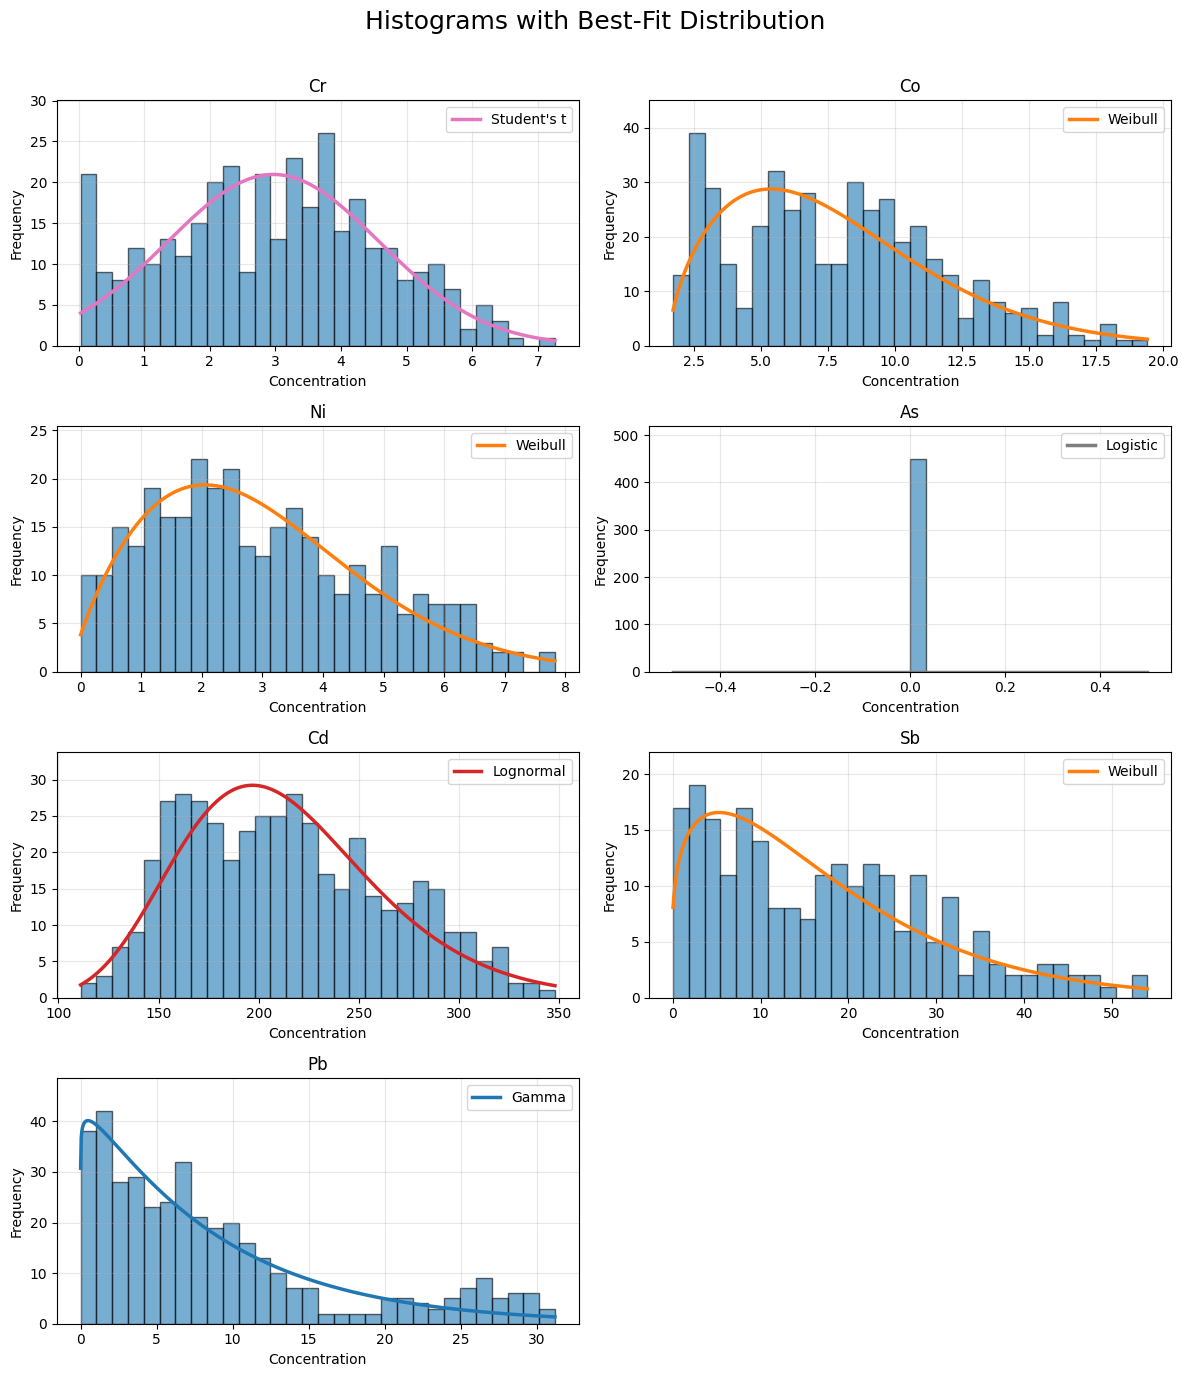

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from google.colab import files
import re, os

# 1) Colab 파일 업로드
print("Upload '202501_clean2.xlsx' and '[9.2] Tx-적합도.xlsx'")
uploaded = files.upload()

INPUT_FILE = None
RANK_FILE = None
for fn in uploaded.keys():
    if "202501_clean2" in fn:
        INPUT_FILE = fn
    elif "[9.2] Tx-적합도" in fn:
        RANK_FILE = fn

if INPUT_FILE is None or RANK_FILE is None:
    raise FileNotFoundError("'202501_clean2.xlsx' 와 '[9.2] Tx-적합도.xlsx' 두 파일 모두 업로드해야 합니다.")

# 2) 분포 이름 매핑 & 설정
DIST_NAME_MAP = {
    "스튜던트의 t": "Student's t",
    "정규": "Normal",
    "로지스틱": "Logistic",
    "와이블": "Weibull",
    "최대 극값": "Maximum Extreme Value",
    "최소 극값": "Minimum Extreme Value",
    "로그 정규": "Lognormal",
    "감마": "Gamma",
    "베타": "Beta",
    "삼각형": "Triangular",
    "균일": "Uniform",
    "지수": "Exponential",
    "파레토": "Pareto",
    "BetaPERT": "BetaPERT"}

DIST_REGISTRY = {
    "Gamma": {"dist": stats.gamma},
    "Weibull": {"dist": stats.weibull_min},
    "Exponential": {"dist": stats.expon},
    "Lognormal": {"dist": stats.lognorm},
    "Maximum Extreme Value": {"dist": stats.gumbel_r},
    "Minimum Extreme Value": {"dist": stats.gumbel_l},
    "Normal": {"dist": stats.norm},
    "Logistic": {"dist": stats.logistic},
    "Student's t": {"dist": stats.t},
    "Beta": {"dist": stats.beta},
    "Triangular": {"dist": stats.triang},
    "Uniform": {"dist": stats.uniform},
    "Pareto": {"dist": stats.pareto},}

DIST_COLORS = {
    "Gamma": "tab:blue",
    "Weibull": "tab:orange",
    "Exponential": "tab:green",
    "Lognormal": "tab:red",
    "Maximum Extreme Value": "tab:purple",
    "Beta": "tab:brown",
    "Student's t": "tab:pink",
    "Logistic": "tab:gray",
    "Normal": "tab:olive",
    "Minimum Extreme Value": "tab:cyan",
    "Triangular": "tab:blue",
    "Pareto": "tab:green",
    "Uniform": "tab:red",}

# 3) 유틸 함수
def find_metal_column(df: pd.DataFrame, metal: str):
    cols = list(df.columns)
    # 완전 일치
    for c in cols:
        if str(c).strip().lower() == metal.lower():
            return c
    # 부분 일치
    cand = [c for c in cols if re.search(rf"\b{re.escape(metal)}\b", str(c), flags=re.I)]
    if cand: return sorted(cand, key=lambda x: len(x))[0]
    # 시작 문자열
    cand = [c for c in cols if str(c).strip().lower().startswith(metal.lower())]
    if cand: return sorted(cand, key=lambda x: len(x))[0]
    return None

def freedman_diaconis_bins(x, min_bins=30, max_bins=70, target_bins=None):
    x = np.asarray(x); x = x[~np.isnan(x)]
    if target_bins is not None and target_bins > 1:
        return int(target_bins)
    q75, q25 = np.percentile(x, [75,25]); iqr = q75 - q25; n = len(x)
    if iqr == 0:
        return max(min_bins, min(max_bins, int(np.sqrt(n))))
    h = 2 * iqr * (n ** (-1/3))
    if h <= 0:
        return max(min_bins, min(max_bins, int(np.sqrt(n))))
    bins = int(np.ceil((x.max() - x.min()) / h))
    return max(2, max(min_bins, min(max_bins, bins)))

# 4) 적합도표에서 Top1 추출
df_rank = pd.read_excel(RANK_FILE, sheet_name="데이터 계열", header=None)

metals = ["Cr","Co","Ni","As","Cd","Sb","Pb"]
rankings = {}

for metal in metals:
    start_idx = df_rank.index[df_rank[0] == metal].tolist()
    if not start_idx:
        continue
    start = start_idx[0] + 2
    block = []
    for i in range(start, len(df_rank)):
        if pd.isna(df_rank.iloc[i,0]) and not pd.isna(df_rank.iloc[i,1]):
            block.append(df_rank.iloc[i,1:9].values)
        else:
            if block: break
    df_block = pd.DataFrame(block, columns=["분포","A-D","A-D P-값","K-S","K-S P-값","카이제곱","카이제곱 P-값","매개 변수"])
    df_block["모수 수"] = df_block["매개 변수"].apply(lambda s: len(str(s).split(",")) if pd.notna(s) else 99)

    df_block_sorted = df_block.sort_values(
        by=["A-D","K-S P-값","카이제곱 P-값","모수 수"],
        ascending=[True, False, False, True])
    rankings[metal] = [DIST_NAME_MAP.get(df_block_sorted.iloc[0]["분포"])]

print("금속별 Top1 분포 (엑셀 기준):")
for m, lst in rankings.items():
    print(m, ":", lst)

# 5) 히스토그램 + 수동 Top1 분포 피팅
df = pd.read_excel(INPUT_FILE)

def manual_fit_plot(metal, dist_list, ax):
    col = find_metal_column(df, metal)
    if col is None:
        ax.set_title(f"{metal} (not found)")
        return
    x = pd.to_numeric(df[col], errors="coerce").dropna().values
    if len(x) < 5:
        ax.set_title(f"{metal} (insufficient data)")
        return

    bins = freedman_diaconis_bins(x, 30, 70)
    counts, edges, _ = ax.hist(x, bins=bins, alpha=0.6, edgecolor="black")
    bin_w = edges[1]-edges[0]
    x_plot = np.linspace(edges[0], edges[-1], 800)

    for dname in dist_list:
        spec = DIST_REGISTRY.get(dname)
        if spec is None:
            print(f"{metal}: 분포 {dname} registry에 없음")
            continue
        try:
            params = spec["dist"].fit(x)   # 자동 적합 수행
            y = spec["dist"].pdf(x_plot, *params)
            plt_y = y * bin_w * len(x)
            color = DIST_COLORS.get(dname, None)
            ax.plot(x_plot, plt_y, lw=2.5, label=dname, color=color)
        except Exception as e:
            print(f"{metal}-{dname} fit error:", e)

    ax.set_ylim(0, ax.get_ylim()[1]*1.1)
    ax.set_title(metal)
    ax.set_xlabel("Concentration")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.grid(alpha=0.3)

# 6) 한 페이지 시각화
n = len(rankings)
n_cols = 2
n_rows = int(np.ceil(n/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.5*n_rows))
axes = axes.flatten()

for idx, (metal, dlist) in enumerate(rankings.items()):
    manual_fit_plot(metal, dlist, axes[idx])

for k in range(idx+1, len(axes)):
    axes[k].axis("off")

fig.suptitle("Histograms with Best-Fit Distribution",
             fontsize=18)
fig.tight_layout(rect=[0,0,1,0.97])
plt.show()